# 상위 100명의 선호도 정보 저장

In [22]:
import pandas as pd

def _df_load(path, state='train'):
    df = pd.read_csv(path)
    df_count = df.groupby(['응답자 ID']).size()
    df_count.name = f'{state} 설문 응답 수'

    return df, df_count

def _top100_filtering(df, top100_ids, state='train', save=True):
    top100_df = df[df['응답자 ID'].isin(top100_ids)].reset_index(drop=True)
    if save:
        top100_df.to_csv(f'top100_{state}_preference.csv', index=False)
    
    return top100_df

def make_top100_csv(train_csv, val_csv, save=True):
    # csv 파일로부터 데이터 불러오기
    df_train, train_count = _df_load(train_csv, 'train')
    df_val, val_count = _df_load(val_csv, 'val')

    # 몇 가지 전처리
    df_sum = pd.concat([train_count, val_count],axis=1)
    df_sum = df_sum.fillna(0).astype(int)    # 결측치 0으로 채우기
    df_sum['합계'] = df_sum['train 설문 응답 수'] + df_sum['val 설문 응답 수']    # '합계' 열 추가
    df_sum = df_sum.sort_values(by='합계', ascending=False)    # '합계' 열 기준으로 내림차순 정렬

    # df_sum의 합계를 기준으로 상위 100개 응답자 ID 추출하여 리스트로 저장
    top100_ids = df_sum.head(100).index.tolist()

    # 상위 100개의 유효한 응답자 ID를 가진 데이터만 추출
    top100_train_df = _top100_filtering(df_train, top100_ids, 'train', save=save)
    top100_val_df = _top100_filtering(df_val, top100_ids, 'val', save=save)

    return top100_train_df, top100_val_df


# Mission 2-2에서 생성한 csv 파일의 경로
t_pref = 'train_preference.csv'
v_pref = 'val_preference.csv'

#t_top100_pref, v_top100_pref = make_top100_csv(t_pref, v_pref, save=True)

# 1. Item-based filtering

### (1) 데이터 준비: user-item 행렬 생성

In [1]:
import pandas as pd

# top100 선호도 데이터 로드
t_top100_pref = pd.read_csv('top100_train_preference.csv')
v_top100_pref = pd.read_csv('top100_val_preference.csv')

# 성능 측정을 위해 "응답자 ID"와 "파일명"을 기준으로 중복된 행만 사용
dup_top100_pref = pd.merge(v_top100_pref, t_top100_pref, on=['응답자 ID', '파일명', '스타일 선호 여부'], how='inner')

# 결과 확인
print(f"원본 v_top100_pref 행 수: {len(v_top100_pref)}")
print(f"중복된 행 수: {len(dup_top100_pref)}")

원본 v_top100_pref 행 수: 1101
중복된 행 수: 646


In [2]:
def make_item_user_matrix(df):
    # 스타일 선호 여부를 1과 0으로 변환
    df['스타일 선호 여부'] = df['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else -1)

    # 선호도 정보를 사용하여 user-item matrix 생성
    user_item_matrix = df.pivot_table(index='응답자 ID', columns='파일명', values='스타일 선호 여부')

    # item-based filtering을 위해 행렬을 전치하여 item-user matrix로 변환(sklearn의 cosine similarity는 row 기준으로 계산이 됨)
    item_user_matrix = user_item_matrix.T

    # 평가하지 않은 item을 확인하기 위해 마스킹 정보 기록
    mask = item_user_matrix.isna()

    # 결측치 0으로 채우기(!0으로 채우는 게 맞을지 고민해보기)
    item_user_matrix.fillna(0, inplace=True)

    return item_user_matrix, mask

t_item_user_matrix, t_mask = make_item_user_matrix(t_top100_pref)
#v_item_user_matrix, v_mask = make_item_user_matrix(v_top100_pref)

In [3]:
t_item_user_matrix      # train 데이터의 item-user matrix

응답자 ID,368,837,7658,7905,9096,20768,21432,22324,28371,28571,...,64633,64662,64747,65071,65139,66469,66513,66592,66731,67975
파일명,,,,,,,,,,,,,,,,,,,,,
T_00253_60_popart_W.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
T_00456_10_sportivecasual_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
T_00588_10_sportivecasual_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
T_00770_60_minimal_W.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
T_00893_90_hiphop_W.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W_71923_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
W_71933_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
W_71934_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### (2) 유사도 계산: Item 간 유사도를 계산하여 비슷한 사용자나 아이템을 찾음

In [4]:
# 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

t_item_similarity_matrix = cosine_similarity(t_item_user_matrix)
#v_item_similarity_matrix = cosine_similarity(v_item_user_matrix)

# 유사도 행렬을 DataFrame으로 변환하여 쉽게 조작할 수 있도록 함
t_item_similarity_df = pd.DataFrame(t_item_similarity_matrix, index=t_item_user_matrix.index, columns=t_item_user_matrix.index)
#v_item_similarity_df = pd.DataFrame(v_item_similarity_matrix, index=v_item_user_matrix.index, columns=v_item_user_matrix.index)

# 아이템 유사도 행렬 확인
t_item_similarity_df

파일명,T_00253_60_popart_W.jpg,T_00456_10_sportivecasual_M.jpg,T_00588_10_sportivecasual_M.jpg,T_00770_60_minimal_W.jpg,T_00893_90_hiphop_W.jpg,T_01322_19_normcore_M.jpg,T_01883_10_sportivecasual_M.jpg,T_02527_10_sportivecasual_M.jpg,T_02558_19_normcore_M.jpg,T_02820_10_sportivecasual_W.jpg,...,W_68175_19_normcore_W.jpg,W_68199_10_sportivecasual_W.jpg,W_71920_60_mods_M.jpg,W_71921_60_mods_M.jpg,W_71922_60_mods_M.jpg,W_71923_60_mods_M.jpg,W_71933_60_mods_M.jpg,W_71934_60_mods_M.jpg,W_71935_60_mods_M.jpg,W_71936_60_mods_M.jpg
파일명,,,,,,,,,,,,,,,,,,,,,
T_00253_60_popart_W.jpg,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T_00456_10_sportivecasual_M.jpg,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T_00588_10_sportivecasual_M.jpg,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T_00770_60_minimal_W.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T_00893_90_hiphop_W.jpg,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W_71923_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
W_71933_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
W_71934_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0


Mean non-zero similarity: 0.0954
Median non-zero similarity: 0.7071
Standard deviation of non-zero similarities: 0.9107


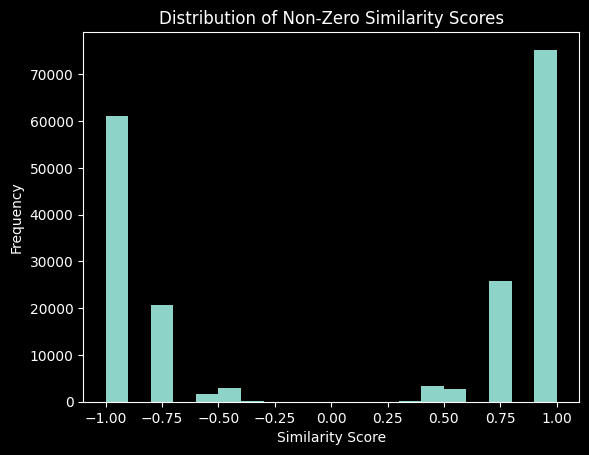

In [34]:
# 임계값 설정을 위한 유사도 행렬의 분포 살펴보기
import numpy as np
import matplotlib.pyplot as plt

# 대각선 요소(자신과의 유사도는 1)와 0(item에 비해 설문의 수가 적어서 0이 너무 많음) 제외
similarities = t_item_similarity_df.values[~np.eye(t_item_similarity_df.shape[0], dtype=bool)]
non_zero_similarities = similarities[similarities != 0]

print(f"Mean non-zero similarity: {np.mean(non_zero_similarities):.4f}")
print(f"Median non-zero similarity: {np.median(non_zero_similarities):.4f}")
print(f"Standard deviation of non-zero similarities: {np.std(non_zero_similarities):.4f}")

plt.hist(non_zero_similarities, bins=20)
plt.title("Distribution of Non-Zero Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

### (3) 추천

In [25]:
def predict_rating(dup_top100_pref, item_similarity_df, mask_df, item_user_matrix):
    predicted_ratings = []      # 아이템의 평점 예측 정보

    for i in range(len(dup_top100_pref)):
        user_id = dup_top100_pref.iloc[i, 0]
        item = dup_top100_pref.iloc[i, 1]

        # user가 평가한 아이템의 index(파일명)
        rated_items = mask_df[user_id].loc[mask_df[user_id] == False].index

        # 평가한 아이템들과의 유사도 행렬
        similar_items = item_similarity_df[item].loc[rated_items]

        # 유사도가 임계값 이상인 항목들만 추출(!임계값은 변경 가능)
        similar_items = similar_items.sort_values(ascending=False)
        top_similar_items = similar_items[similar_items >= 0.7]     # 임계값: 0.7

        # top_similar_items의 유사도에 사용자 평점을 가중 평균하여 예측 평점 계산
        weighted_ratings_sum = 0    # 가중 평점의 합(분자)
        similarity_sum = 0          # 모든 유사도의 합(분모)

        # 사용자가 평가한 아이템만 고려하여 선호도 예측
        for similar_item in top_similar_items.index:
            if similar_item == item:    # 자기 자신은 제외
                continue
            similarity = top_similar_items[similar_item]
            rating = item_user_matrix[[user_id]].loc[similar_item].values
            weighted_ratings_sum += similarity * rating
            similarity_sum += similarity

        if similarity_sum != 0:
            predicted_rating = weighted_ratings_sum / similarity_sum
        else:
            predicted_rating = 0

        # 예측된 선호도 저장
        predicted_ratings.append([user_id, item, predicted_rating])
    
    # 다루기 쉽게 DataFrame으로 변환
    predicted_df = pd.DataFrame(predicted_ratings, columns=['응답자 ID', '파일명', '예측된 선호도'])

    return predicted_df


predicted_ratings = predict_rating(dup_top100_pref, t_item_similarity_df, t_mask, t_item_user_matrix)
predicted_ratings

,응답자 ID,파일명,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,0
1,368,W_15340_50_ivy_M.jpg,[-1.0]
2,368,W_01703_00_metrosexual_M.jpg,[1.0]
3,368,W_12817_50_ivy_M.jpg,0
4,368,W_06551_60_mods_M.jpg,[-1.0]
...,...,...,...
641,67975,W_17747_80_bold_M.jpg,0
642,67975,T_21986_70_hippie_M.jpg,[-1.0]
643,67975,W_26965_90_hiphop_M.jpg,[-1.0]
644,67975,T_21992_70_hippie_M.jpg,[-1.0]


In [26]:
# 실제 스타일 선호 여부와 예측된 선호 여부 비교
total_dup_pref = dup_top100_pref.merge(predicted_ratings, on=['응답자 ID', '파일명'], how='left')
total_dup_pref['스타일 선호 여부'] = total_dup_pref['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else -1)

# 확실히 선호하는 경우만 1로, 그렇지 않은 경우 -1로 변환(0도 -1로 변환됨)
total_dup_pref['예측된 선호도'] = total_dup_pref['예측된 선호도'].apply(lambda x: 1 if x > 0 else -1)
total_dup_pref

,응답자 ID,파일명,스타일 선호 여부,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,1,-1
1,368,W_15340_50_ivy_M.jpg,-1,-1
2,368,W_01703_00_metrosexual_M.jpg,1,1
3,368,W_12817_50_ivy_M.jpg,1,-1
4,368,W_06551_60_mods_M.jpg,-1,-1
...,...,...,...,...
641,67975,W_17747_80_bold_M.jpg,-1,-1
642,67975,T_21986_70_hippie_M.jpg,-1,-1
643,67975,W_26965_90_hiphop_M.jpg,-1,-1
644,67975,T_21992_70_hippie_M.jpg,-1,-1


In [27]:
# 성능지표 평가 (Accuracy / Precision / Recall)
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])
precision = precision_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])
recall = recall_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Accuracy: 0.9737, Precision: 1.0000, Recall: 0.9306


# 2. User-based filtering

### (1) 데이터 준비: user-item 행렬 생성

In [1]:
import pandas as pd

# top100 선호도 데이터 로드
t_top100_pref = pd.read_csv('top100_train_preference.csv')
v_top100_pref = pd.read_csv('top100_val_preference.csv')

# 성능 측정을 위해 "응답자 ID"와 "파일명"을 기준으로 중복된 행만 사용
dup_top100_pref = pd.merge(v_top100_pref, t_top100_pref, on=['응답자 ID', '파일명', '스타일 선호 여부'], how='inner')

# 결과 확인
print(f"원본 v_top100_pref 행 수: {len(v_top100_pref)}")
print(f"중복된 행 수: {len(dup_top100_pref)}")

원본 v_top100_pref 행 수: 1101
중복된 행 수: 646


In [2]:
def make_user_item_matrix(df):
    # 스타일 선호 여부를 1과 0으로 변환
    df['스타일 선호 여부'] = df['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else -1)

    # 선호도 정보를 사용하여 user-item matrix 생성
    user_item_matrix = df.pivot_table(index='응답자 ID', columns='파일명', values='스타일 선호 여부')

    # 평가하지 않은 user을 확인하기 위해 마스킹 정보 기록
    mask = user_item_matrix.isna()

    # 결측치 0으로 채우기(!0으로 채우는 게 맞을지 고민해보기)
    user_item_matrix.fillna(0, inplace=True)

    return user_item_matrix, mask

t_user_item_matrix, t_mask = make_user_item_matrix(t_top100_pref)
#v_user_item_matrix, v_mask = make_user_item_matrix(v_top100_pref)

### (2) 유사도 계산: User 간 유사도를 계산하여 비슷한 사용자나 아이템을 찾음

In [3]:
# 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

t_user_similarity_matrix = cosine_similarity(t_user_item_matrix)

# 유사도 행렬을 DataFrame으로 변환하여 쉽게 조작할 수 있도록 함
t_user_similarity_df = pd.DataFrame(t_user_similarity_matrix, index=t_user_item_matrix.index, columns=t_user_item_matrix.index)

# User 유사도 행렬 확인
t_user_similarity_df

응답자 ID,368,837,7658,7905,9096,20768,21432,22324,28371,28571,...,64633,64662,64747,65071,65139,66469,66513,66592,66731,67975
응답자 ID,,,,,,,,,,,,,,,,,,,,,
368,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.022473,...,0.022990,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.022751,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7658,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7905,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.02299,-0.023531,0.000000,...,0.023256,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9096,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66469,0.0,0.0,0.0,0.0,0.0,0.0,0.022751,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
66513,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
66592,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.021979,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Mean non-zero similarity: 0.0109
Median non-zero similarity: 0.0220
Standard deviation of non-zero similarities: 0.0219


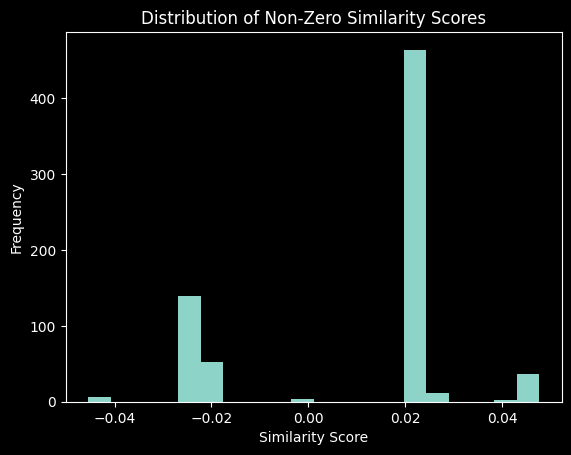

In [4]:
# 임계값 설정을 위한 유사도 행렬의 분포 살펴보기
import numpy as np
import matplotlib.pyplot as plt

# 대각선 요소(자신과의 유사도는 1)와 0(item에 비해 설문의 수가 적어서 0이 너무 많음) 제외
similarities = t_user_similarity_df.values[~np.eye(t_user_similarity_df.shape[0], dtype=bool)]
non_zero_similarities = similarities[similarities != 0]

print(f"Mean non-zero similarity: {np.mean(non_zero_similarities):.4f}")
print(f"Median non-zero similarity: {np.median(non_zero_similarities):.4f}")
print(f"Standard deviation of non-zero similarities: {np.std(non_zero_similarities):.4f}")

plt.hist(non_zero_similarities, bins=20)
plt.title("Distribution of Non-Zero Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

### (3) 추천

In [5]:
def predict_rating(dup_top100_pref, user_similarity_df, mask_df, user_item_matrix):
    predicted_ratings = []      # 아이템의 평점 예측 정보

    for i in range(len(dup_top100_pref)):
        user_id = dup_top100_pref.iloc[i, 0]
        item = dup_top100_pref.iloc[i, 1]

        # 해당 item을 평가한 user의 index(userID)
        rated_user = mask_df[item].loc[mask_df[item] == False].index

        # 평가한 user들과의 유사도 행렬
        similar_users = user_similarity_df[user_id].loc[rated_user]

        # 유사도가 임계값 이상인 항목들만 추출(!임계값은 변경 가능)
        similar_users = similar_users.sort_values(ascending=False)
        #top_similar_users = similar_users[similar_users >= 0.5]
        top_similar_users = similar_users       # 유사도가 너무 낮아서 모든 유저를 고려

        # top_similar_users의 유사도에 사용자 평점을 가중 평균하여 예측 평점 계산
        weighted_ratings_sum = 0    # 가중 평점의 합(분자)
        similarity_sum = 0          # 모든 유사도의 합(분모)

        # item을 평가한 user만 고려하여 선호도 예측
        for similar_user in top_similar_users.index:
            if similar_user == user_id:    # 자기 자신은 제외
                continue
            similarity = top_similar_users[similar_user]
            rating = user_item_matrix[[item]].loc[similar_user].values
            weighted_ratings_sum += similarity * rating
            similarity_sum += similarity

        if similarity_sum != 0:
            predicted_rating = weighted_ratings_sum / similarity_sum
        else:
            predicted_rating = 0

        # 예측된 선호도 저장
        predicted_ratings.append([user_id, item, predicted_rating])
    
    # 다루기 쉽게 DataFrame으로 변환
    predicted_df = pd.DataFrame(predicted_ratings, columns=['응답자 ID', '파일명', '예측된 선호도'])

    return predicted_df


predicted_ratings = predict_rating(dup_top100_pref, t_user_similarity_df, t_mask, t_user_item_matrix)
predicted_ratings

,응답자 ID,파일명,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,[1.0]
1,368,W_15340_50_ivy_M.jpg,0
2,368,W_01703_00_metrosexual_M.jpg,0
3,368,W_12817_50_ivy_M.jpg,[1.9371204397585957]
4,368,W_06551_60_mods_M.jpg,0
...,...,...,...
641,67975,W_17747_80_bold_M.jpg,[-177.99438184514835]
642,67975,T_21986_70_hippie_M.jpg,0
643,67975,W_26965_90_hiphop_M.jpg,0
644,67975,T_21992_70_hippie_M.jpg,0


In [6]:
# 실제 스타일 선호 여부와 예측된 선호 여부 비교
total_dup_pref = dup_top100_pref.merge(predicted_ratings, on=['응답자 ID', '파일명'], how='left')
total_dup_pref['스타일 선호 여부'] = total_dup_pref['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else -1)

# 확실히 선호하는 경우만 1로, 그렇지 않은 경우 -1로 변환
total_dup_pref['예측된 선호도'] = total_dup_pref['예측된 선호도'].apply(lambda x: 1 if x > 0 else -1)
total_dup_pref

,응답자 ID,파일명,스타일 선호 여부,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,1,1
1,368,W_15340_50_ivy_M.jpg,-1,-1
2,368,W_01703_00_metrosexual_M.jpg,1,-1
3,368,W_12817_50_ivy_M.jpg,1,1
4,368,W_06551_60_mods_M.jpg,-1,-1
...,...,...,...,...
641,67975,W_17747_80_bold_M.jpg,-1,-1
642,67975,T_21986_70_hippie_M.jpg,-1,-1
643,67975,W_26965_90_hiphop_M.jpg,-1,-1
644,67975,T_21992_70_hippie_M.jpg,-1,-1


In [7]:
# 성능지표 평가 (Accuracy / Precision / Recall)
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])
precision = precision_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])
recall = recall_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Accuracy: 0.6579, Precision: 0.6579, Recall: 0.2041


### (4) 결과 해석

> 유사도 0.5 이상의 user를 비슷하다 간주하여 실행하면 모든 결과를 0으로 뱉는다.<br>
> 이유를 확인해보니 user의 갯수가 너무 적어서(100명) 유사한 유저가 전혀 없다고 판단하는 것 같다.

In [8]:
# user 간 유사도 행렬
t_user_similarity_df

응답자 ID,368,837,7658,7905,9096,20768,21432,22324,28371,28571,...,64633,64662,64747,65071,65139,66469,66513,66592,66731,67975
응답자 ID,,,,,,,,,,,,,,,,,,,,,
368,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.022473,...,0.022990,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.022751,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7658,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7905,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.02299,-0.023531,0.000000,...,0.023256,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9096,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66469,0.0,0.0,0.0,0.0,0.0,0.0,0.022751,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
66513,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
66592,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.021979,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
# 가장 높은 유사도를 가진 값 확인
user_similar_df.values.max()

0.04767312946227962

In [9]:
# 유사도가 높은(0.5 이상) user 정보를 확인
import numpy as np
user_similar_df = t_user_similarity_df.copy()

# 대각 행렬을 0으로 만들기
np.fill_diagonal(user_similar_df.values, 0)

# 유사도가 0.5 이상인 요소만 남기고 나머지는 0으로 설정
df_filtered = user_similar_df.where(user_similar_df >= 0.5, 0)

# 각 행에서 0이 아닌 값을 가진 열만 선택
result = df_filtered.apply(lambda x: x[x != 0])

# 결과 출력
result

응답자 ID,368,837,7658,7905,9096,20768,21432,22324,28371,28571,...,64633,64662,64747,65071,65139,66469,66513,66592,66731,67975
응답자 ID,,,,,,,,,,,,,,,,,,,,,


> 놀랍게도 유사도가 0.5 이상인 user는 단 1명도 없으며, 가장 큰 유사도를 가진 user도 0.047이다.<br>
> 유사도 계산 방법과 encoding 방법에 따라 달라질 수는 있겠으나, 아무래도 user에 비해 item의 수가 훨씬 많다보니 이런 결과가 나오는 것 같다.